SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1024                                                  NAXIS2  =                 1024                                                  EXTEND  =                    T                                                  COMMENT   FITS (Flexible Image Transport System) format is defined in 'AstronomyCOMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H CAL_ARCH= '61130833202621'     / Archon time in 10ns per tick at CAL_SYS        CAL_SYS = '2023-12-06T09:24:01.685090' / system time at CAL_ARCH                CAMD_VER= 'Nov 26 2023 20:21:34' / camerad build date                           COADDS  =                    4 / number of coadds                               FILENAME= 'n0097.fits'         / this fi

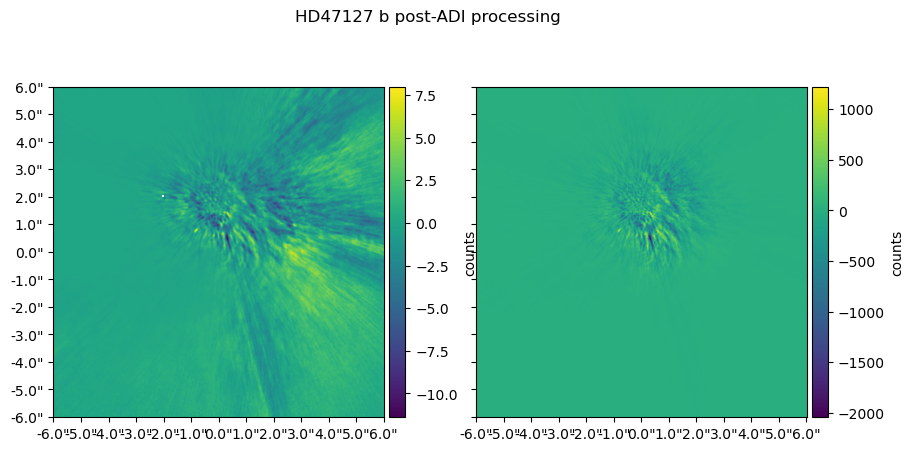

In [7]:
#import packages
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import glob
import pyklip
import pyklip.klip as klip
from pyklip.kpp.utils.mathfunc import *
from pyklip.kpp.metrics.crossCorr import calculate_cc
import astropy.units as u
from importlib import reload
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pyklip.kpp.stat.stat_utils import get_image_stat_map
%matplotlib inline

#define functions for display
def add_label(ax,txt,imsz):
    ax.text(5,imsz-10,txt,c='w',size=18)
    
def add_cbar(im,ax,f,lb="counts"):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right',size='5%',pad=0.05)
    f.colorbar(im,cax=cax,orientation='vertical',label=lb)
    
def set_display(stampsz,stampcen=None,tickint=1):
    if stampcen == None:
        stampcen = ((stampsz-1)/2.,(stampsz-1)/2.)
    mnx=int(stampcen[0]-stampsz/2)
    mxx=int(stampcen[0]+stampsz/2+1)
    mny=int(stampcen[1]-stampsz/2)
    mxy=int(stampcen[1]+stampsz/2+1)
    ranges=(mnx,mxx,mny,mxy)
    platescale=.02 ###for GPI its .01414
    nticks=np.floor(stampsz*platescale/2/tickint)
    ticklabels=np.arange(-1*nticks,nticks+1)*tickint
    ticklabels_str=[str(lab)+'\"' for lab in ticklabels]
    ticks = ticklabels/platescale + stampsz/2
    return(ranges,ticks,ticklabels_str)

#define ADI process
def cADI_NIRC2(flist, write_intermediate=False):
    
    #get data from fits, create raw image arrays
    #could use either one single SNR map or the median of all SNR maps
    rawcube = np.zeros((len(flist),1024,1024))
    image_cc = np.zeros((len(flist),1024,1024))
    #SNR_map = np.zeros((len(flist),1024,1024))
    #image_cc = np.zeros((1024,1024))     
    SNR_map = np.zeros((1024,1024))     
    subcube = np.zeros((len(flist),1024,1024))
    derotcube = np.zeros((len(flist),1024,1024))
    
    x_grid,y_grid= np.meshgrid(np.arange(507,517),np.arange(507,517))
    kernel_gauss = gauss2d(x_grid,y_grid, amplitude = 40.0, xo = 512.0, yo = 512.0, sigma_x = 1.0, sigma_y = 1.0)
    center = [512,512]
    ctrs = []
    vertangs = []
    for i in np.arange(len(flist)):
        rawcube[i,:,:] = fits.getdata(flist[i])
        head = fits.getheader(flist[i],ext=0)
        if i == 0:
            print(head)
        #need RAOFF, DECOFF, resolution/RA per pixel
        #printstr = 'DPIXX: ' + str(head['DPIXX']) + ' DPIXY: ' + str(head['DPIXY'])
        #printstr = ''
        #printstr = 'RA: ' + str(head['RA']) + ' DEC: ' + str(head['DEC']) + ' TARGRA: ' + str(head['TARGRA']) + ' TARGDEC: ' + str(head['TARGDEC']) + ' RAOFF: ' + str(head['RAOFF']) + ' DECOFF: ' + str(head['DECOFF'])
        #print(printstr)
        cen = (head['STARCX'], head['STARCY']) ##cross-correlation, poisson
        ctrs.append(cen)
        #va = head['PARANTEL'] - head['PARANG']
        #va = head['ROTPOSN']
        va = -1*head['PARANG'] + head['ROTPPOSN'] - head['INSTANGL']
        #print(va)
        vertangs.append(va) ##check paper
        
        
        
        #center the images at same point using cross-correlation
        
    #rotate images and align
    medcube = np.nanmedian(rawcube,axis=0)
    
    cccube = np.zeros((1024,1024))
    for i in np.arange(len(flist)):
        subcube[i,:,:] =  rawcube[i,:,:] - medcube
        
        derotcube[i,:,:] = klip.rotate(subcube[i,:,:], vertangs[i], ctrs[i], new_center=(612,412))
        ##check tutorial
        #derotcube[i,:,:] = klip.rotate(subcube[i,:,:], vertangs[i], ctrs[i], new_center=(612,412))
        #derotcube[i,:,:] = calculate_cc(derotcube[i,:,:],kernel_gauss,spectrum=None,nans2zero=True)
    #take median and return
    #medsnr = np.nanmedian(SNR_map, axis=0)    #uncomment if taking median SNR
    med_derot = np.nanmedian(derotcube, axis=0)
    fits.writeto('new.fits',med_derot,overwrite=True)
    cccube[:,:] = calculate_cc(med_derot[:,:],kernel_gauss,spectrum=None,nans2zero=True)
    SNR_map[:,:] = get_image_stat_map(cccube,
                                               centroid = center,
                                               r_step=2,
                                               Dr = 2,
                                               type = "SNR")
    fits.writeto('askjdbawud.fits',SNR_map,overwrite=True)
    return SNR_map, med_derot


datadir = 'HD47127_data/Dec_2023/'
flist = sorted(glob.glob(datadir + '*.fits'))
stampsz = 600
rg, ticks, ticklabels_str = set_display(stampsz, stampcen=(412,612))
mnx,mxx,mny,mxy = rg

flist_adi, med = cADI_NIRC2(flist, write_intermediate=False)
f,(ax1, ax2) = plt.subplots(1,2,sharex=True,sharey=True,figsize=(10,5))
f.suptitle("HD47127 b post-ADI processing")
im1 = ax1.imshow(flist_adi[mnx:mxx,mny:mxy],origin='lower')
im2 = ax2.imshow(med[mnx:mxx,mny:mxy],origin='lower')
plt.xticks(ticks,labels=ticklabels_str)
plt.yticks(ticks,labels=ticklabels_str)
add_cbar(im1,ax1,f)
add_cbar(im2,ax2,f)

#NAXIS: num of axes
#NAXIS1: length of axis
#RA
#DEC
#TARGRA
#TARGDEC
#RAOFF, DECOFF: DCS RA, Dec offset
#PARANG: parallactic angle astrometric
#CENWAVE: central wavelength of passband
#MINWAVE, MAXWAVE
#EFFWAVE: effective wavelength of passband
#LTM1_1, LTM2_2, CD1_1, CD1_2, CD2_1, CD2_2
#ELAPTIME: total integration time
#PSFCX, PSFCY: center of PSF in pixels
#STARCX, STARCY: center of star in pixels
#PIXSCALE, PIXSCAL1, PIXSCAL2: arcsec per pixel




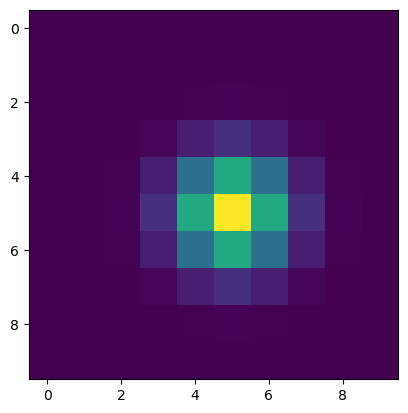

In [9]:
x_grid,y_grid= np.meshgrid(np.arange(507,517),np.arange(507,517))
kernel_gauss = gauss2d(x_grid,y_grid, amplitude = 40.0, xo = 512.0, yo = 512.0, sigma_x = 1.0, sigma_y = 1.0)
f1, ax = plt.subplots(1,1)
im = ax.imshow(kernel_gauss)